<a href="https://colab.research.google.com/github/wkdwlgus/ktcloud_genai/blob/main/251016_%EB%B6%84%EB%A5%98%EC%9A%A9_%ED%91%9C%ED%98%84_%EB%AF%B8%EC%84%B8_%ED%8A%9C%EB%8B%9D%ED%95%98%EA%B8%B0_%EC%9E%A5%EC%A7%80%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **분류용 표현 모델 미세 튜닝하기 - 한글**

In [ ]:
%%capture
!pip install datasets setfit seqeval evaluate

- **datasets** :
    - https://huggingface.co/datasets
    - 허깅페이스 데이터셋
- **setfit** :
    - https://huggingface.co/docs/setfit/index
    - 적은 양의 레이블 데이터만으로 문장 변환(Sentence Transformer) 모델을 효율적으로 파인튜닝하기 위한 프레임워크
- **seqeval** : (평가지표)
    - https://huggingface.co/spaces/evaluate-metric/seqeval
    - 개체명 인식(NER:Named Entity Recognition)과 같은 시퀀스 레이블링(sequence labeling) 태스크의 성능(F1-score, 정밀도 등)을 평가하기 위한 라이브러리

## **데이터**
- 모델: `'klue/bert-base'`
- 데이터: NSMC(Naver Sentiment Movie Corpus)
https://huggingface.co/datasets/Blpeng/nsmc
  - train: 150,000개
  - test: 50,000개
  - Rotten Tomatoes와 유사한 한글 데이터셋

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 데이터를 준비하고 분할합니다. 결측값을 제거합니다.
dataset = load_dataset("Blpeng/nsmc")
train_data = dataset['train'].filter(lambda x: x['document'] is not None).shuffle(seed=42).select(range(8500))
test_data = dataset['test'].filter(lambda x: x['document'] is not None).shuffle(seed=42).select(range(1000))

# 모델과 토크나이저를 로드합니다.
model_id = "klue/bert-base"
model = AutoModelForSequenceClassification.from_pretrained(
            model_id, num_labels=2)  # 레이블 개수 2개
tokenizer = AutoTokenizer.from_pretrained(model_id)

Repo card metadata block was not found. Setting CardData to empty.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_data

Dataset({
    features: ['Unnamed: 0', 'id', 'document', 'label'],
    num_rows: 8500
})

In [ ]:
test_data

Dataset({
    features: ['Unnamed: 0', 'id', 'document', 'label'],
    num_rows: 1000
})

In [ ]:
train_data[1]

{'Unnamed: 0': 67616, 'id': 7480534, 'document': '이런 영화는 북쪽이나 틀어라', 'label': 0}



---



## **지도 분류**


데이터를 토큰으로 나눕니다.

In [ ]:
def preprocess_function(examples):
   """입력 데이터를 토큰으로 나눕니다"""
   return tokenizer(examples["document"], truncation=True)

# 훈련 데이터와 테스트 데이터를 토큰화합니다.
# batched = True -> 여러개 데이터를 배치단위(batch size 만큼 묶어서) 처리 (메모리 문제)
# batch_size = 1000 (default)
# batched = False -> 데이터를 하나씩 개별 처리 (시간 문제)
# => 메모리 시간 trade off
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

DataCollator: 배치 데이터를 만들고 데이터 증식도 적용할 수 있는 클래스

In [ ]:
import torch
# DataCollactor가 왜 필요할까?
# 토큰화된 데이터
sample1 = {"input_ids": [101, 146, 1567, 102]}                    # 길이 4
sample2 = {"input_ids": [101, 1188, 1110, 2213, 999, 102]}        # 길이 6
sample3 = {"input_ids": [101, 2026, 2523, 106, 102]}              # 길이 5

# 배치로 묶으려면?
batch = [sample1, sample2, sample3]

# ❌ 텐서로 변환 불가능! (길이가 달라서)
tensor = torch.tensor([
    [101, 146, 1567, 102],           # 4개
    [101, 1188, 1110, 2213, 999, 102],  # 6개  ← 에러!
    [101, 2026, 2523, 106, 102]      # 5개
])

ValueError: expected sequence of length 4 at dim 1 (got 6)

In [ ]:
from transformers import DataCollatorWithPadding

# 배치에서 가장 긴 시퀀스에 맞춰 패딩합니다.
# data_collator(samples) 혹은 trainer.train() 시점에 패딩이 추가됨
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

측정 지표를 정의합니다. (confusion matrix)

- **F1-score**
    - **정밀도(Precision)와 재현율(Recall)의 조화평균**
    - 데이터 불균형(Imbalanced Data)이 심할 때 모델의 성능을 정확하게 평가하기 위해 주로 사용
    - 정밀도(Precision)와 재현율(Recall)을 모두 중요하게 고려해야 할 때 사용

정밀도 (Precision) = TP / (TP + FP)
- 긍정이라고 예측한 것 중 실제 긍정 비율

재현율 (Recall) = TP / (TP + FN)
- 실제 긍정 중 긍정으로 예측한 비율

F1-Score = 2 × (Precision × Recall) / (Precision + Recall)
- 정밀도와 재현율의 조화평균
- 불균형 데이터 -> **실제: 스팸 10개, 정상 90개**

- 모델이 모두 "정상"이라고 예측 -> **예측: 전부 정상**

- 정확도 = 90/100 = 90%  ← 높아 보이지만...
스팸을 하나도 못 잡음! ❌
- 정밀도 = 0 / (0 + 0) = 계산 불가
- 재현율 = 0 / (0 + 10) = 0%
- F1-Score = 0%  ← 실제 성능 반영! ✅

In [ ]:
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    """F1 점수를 계산합니다"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

모델을 훈련합니다.

In [ ]:
from transformers import TrainingArguments, Trainer

# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,              # 0.00002
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# 훈련 과정을 수행할 Trainer 객체
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss
500,0.377500


TrainOutput(global_step=532, training_loss=0.371744121823992, metrics={'train_runtime': 29.9852, 'train_samples_per_second': 283.473, 'train_steps_per_second': 17.742, 'total_flos': 275847274883520.0, 'train_loss': 0.371744121823992, 'epoch': 1.0})

모델을 평가합니다.
eval_f1 으로 평가 (1에 가까울수록 정확도 높은거(성능 높은거))

In [ ]:
trainer.evaluate()
# 0.883

{'eval_loss': 0.2849462330341339,
 'eval_f1': 0.8830897703549061,
 'eval_runtime': 1.4523,
 'eval_samples_per_second': 688.545,
 'eval_steps_per_second': 43.378,
 'epoch': 1.0}

### **Layer Freezing**

In [ ]:
# 모델과 토크나이저를 로드합니다.
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 층 이름을 출력합니다.
i = 0
for name, params in model.named_parameters():
    print(f'{i}:', name)
    i += 1

0: bert.embeddings.word_embeddings.weight
1: bert.embeddings.position_embeddings.weight
2: bert.embeddings.token_type_embeddings.weight
3: bert.embeddings.LayerNorm.weight
4: bert.embeddings.LayerNorm.bias
5: bert.encoder.layer.0.attention.self.query.weight
6: bert.encoder.layer.0.attention.self.query.bias
7: bert.encoder.layer.0.attention.self.key.weight
8: bert.encoder.layer.0.attention.self.key.bias
9: bert.encoder.layer.0.attention.self.value.weight
10: bert.encoder.layer.0.attention.self.value.bias
11: bert.encoder.layer.0.attention.output.dense.weight
12: bert.encoder.layer.0.attention.output.dense.bias
13: bert.encoder.layer.0.attention.output.LayerNorm.weight
14: bert.encoder.layer.0.attention.output.LayerNorm.bias
15: bert.encoder.layer.0.intermediate.dense.weight
16: bert.encoder.layer.0.intermediate.dense.bias
17: bert.encoder.layer.0.output.dense.weight
18: bert.encoder.layer.0.output.dense.bias
19: bert.encoder.layer.0.output.LayerNorm.weight
20: bert.encoder.layer.0.outpu

classifier(분류 헤드) 를 제외한 모든 층 동결하기

In [ ]:
for name, param in model.named_parameters():

     # 분류 헤드는 동결하지 않습니다.
     if name.startswith("classifier"):

        # 역전파시 그래디언트(dloss/dweight) 계산 여부 결정
        # 이 파라미터는 훈련 중에 업데이트되어야 한다는 의미
        param.requires_grad = True


     # 그외 모든 층을 동결합니다.
     else:
        param.requires_grad = False


In [ ]:
# 모델이 올바르게 업데이트되었는지 확인합니다.
for index, (name, param) in enumerate(model.named_parameters()):

  print(f"{index}: {name} ----- {param.requires_grad} --- {param.shape}")

# 동결 안한 층(분류 헤드)
#  - classifier.weight
#  - classifier.bias

0: bert.embeddings.word_embeddings.weight ----- False --- torch.Size([32000, 768])
1: bert.embeddings.position_embeddings.weight ----- False --- torch.Size([512, 768])
2: bert.embeddings.token_type_embeddings.weight ----- False --- torch.Size([2, 768])
3: bert.embeddings.LayerNorm.weight ----- False --- torch.Size([768])
4: bert.embeddings.LayerNorm.bias ----- False --- torch.Size([768])
5: bert.encoder.layer.0.attention.self.query.weight ----- False --- torch.Size([768, 768])
6: bert.encoder.layer.0.attention.self.query.bias ----- False --- torch.Size([768])
7: bert.encoder.layer.0.attention.self.key.weight ----- False --- torch.Size([768, 768])
8: bert.encoder.layer.0.attention.self.key.bias ----- False --- torch.Size([768])
9: bert.encoder.layer.0.attention.self.value.weight ----- False --- torch.Size([768, 768])
10: bert.encoder.layer.0.attention.self.value.bias ----- False --- torch.Size([768])
11: bert.encoder.layer.0.attention.output.dense.weight ----- False --- torch.Size([768,

In [ ]:
from transformers import TrainingArguments, Trainer

# 훈련 과정을 실행할 Trainer 객체를 만듭니다.
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.680400


TrainOutput(global_step=532, training_loss=0.6790811997607238, metrics={'train_runtime': 12.2025, 'train_samples_per_second': 696.576, 'train_steps_per_second': 43.597, 'total_flos': 275847274883520.0, 'train_loss': 0.6790811997607238, 'epoch': 1.0})

In [ ]:
trainer.evaluate()
# 0.646

{'eval_loss': 0.6491261124610901,
 'eval_f1': 0.646,
 'eval_runtime': 1.4295,
 'eval_samples_per_second': 699.526,
 'eval_steps_per_second': 44.07,
 'epoch': 1.0}

### **partial fine-tuning: 10개의 인코더 블록 동결하기**

In [ ]:
# 모델과 토크나이저를 로드합니다.
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
'''
<하드코딩>
11번째 인코더 블록은 인덱스 165에서 시작합니다.
이 블록 이전의 모든 층을 동결합니다.
for index, (name, param) in enumerate(model.named_parameters()):
if index < 165:
param.requires_grad = False
'''

# 항상 11층이 165행부터가 아닐 수도 있기 때문에, 하드코딩 말고 동결시킬 레이어 층을 명시적으로 이용

# BERT 전체 동결
for param in model.bert.parameters():
    param.requires_grad = False

# 몇 층까지 동결시킬지
num_layers_to_freeze = 10

# 11개 ~ 마지막 레이어층까진 그래디언트 계산 o
for i in range(num_layers_to_freeze, 12):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = True

# Pooler 학습 (CLS 토큰 변환층)
for param in model.bert.pooler.parameters():
    param.requires_grad = True

# 헤드(Classifier) 학습
for param in model.classifier.parameters():
    param.requires_grad = True  # ✏️

# 훈련 과정을 실행할 Trainer 객체를 만듭니다.
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()
# 0.85

Step,Training Loss
500,0.439600


{'eval_loss': 0.3499554395675659,
 'eval_f1': 0.8497409326424871,
 'eval_runtime': 1.3457,
 'eval_samples_per_second': 743.11,
 'eval_steps_per_second': 46.816,
 'epoch': 1.0}

### partial fine-tuning 이유

1. 학습 속도 향상
  - 동결된 층은 그래디언트 계산을 하지 않음


2. 메모리 절약
  - 그래디언트 저장 안 함 -> GPU 메모리 절약
  

3. 학습 안정성 향상 -> 과적합 방지
  - 데이터 적을 때 -> 학습 파라미터 down -> 과적합 위험 down
4. 사전 학습 지식 보존
  - 하위 층의 일반적 언어 지식 유지
  - Catastrophic Forgetting 방지
  - 상위 층만 새 태스크에 특화 (ex: 감정 분석에 필요한 부분만 조정)
5. 전이학습, 다중 태스크 학습 용이


### **인코더 블록 동결의 효과**
인코더 블록을 점차 훈련하면 모든 인코더 블록을 훈련했을 때의 성능과 거의 비슷한 수준에 도달합니다.

In [ ]:
# 시간이 오래 걸립니다!
scores = []
# 레이어를 하나씩 증가시키면서 어느 레이어까지 동결시켜야 (훈련시켜야) 성능이 좋은지 확인
for index in range(12):
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # 인코더 블록 0-index를 동결합니다.
    for name, param in model.named_parameters():
        if "layer" in name:
            layer_nr = int(name.split("layer")[1].split(".")[1])
            if layer_nr <= index:
                param.requires_grad = False
        else:
            param.requires_grad = True

    # 모델 훈련
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      processing_class=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
    )
    trainer.train()

    # 평가
    score = trainer.evaluate()["eval_f1"]
    scores.append(score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.375100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.375800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.377000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.379100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.381800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.384900


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.390300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.399300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.415700


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.436400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.458000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.516600


In [ ]:
scores

[0.8840125391849529,
 0.8840579710144928,
 0.8840579710144928,
 0.8778467908902692,
 0.8775933609958506,
 0.8746113989637305,
 0.8731808731808732,
 0.8652037617554859,
 0.867570385818561,
 0.8532778355879292,
 0.8471074380165289,
 0.8229166666666666]

In [ ]:
!pip install kneed

- 자동 탐지된 최적 동결 지점: 0-3
- 해당 F1-score: 0.8676
- 전체 학습(All) 대비 성능: 98.1%
- 학습 레이어 비율: 33.3%


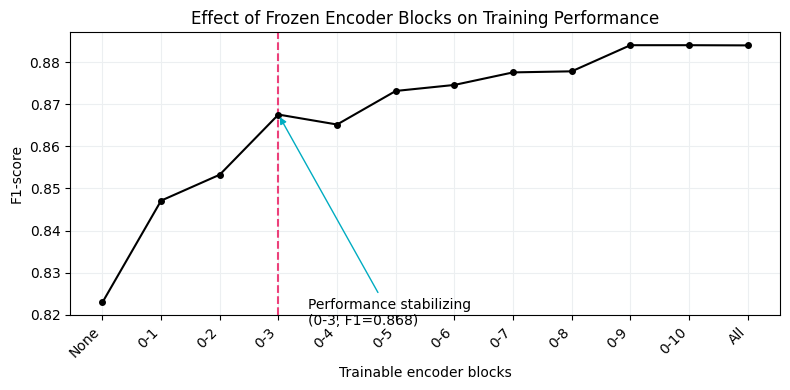

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from kneed import KneeLocator

# figure 객체를 만듭니다.
plt.figure(figsize=(8,4))

# 데이터를 준비합니다.
x = [f"0-{index}" for index in range(12)]
x[0] = "None"
x[-1] = "All"
y = scores[::-1]

# 숫자 x축 (KneeLocator용)
x_values = list(range(len(y)))

# KneeLocator로 자동으로 최적점 찾기
kn = KneeLocator(
    x_values,
    y,
    curve='concave',      # 위로 볼록한 곡선
    direction='increasing' # 증가하는 방향
)
optimal_point = kn.elbow

# 그래프 스타일 설정
plt.grid(color='#ECEFF1')

# 자동으로 찾은 최적점에 선 그리기
plt.axvline(x=optimal_point, color="#EC407A", linestyle="--")

plt.title("Effect of Frozen Encoder Blocks on Training Performance")
plt.ylabel("F1-score")
plt.xlabel("Trainable encoder blocks")

# 그래프를 그립니다.
plt.plot(x_values, y, color="black", marker='o', markersize=4)

# 그래프 주석 추가 (자동으로 찾은 지점)
plt.annotate(
    f'Performance stabilizing\n({x[optimal_point]}, F1={y[optimal_point]:.3f})',
    xy=(optimal_point, y[optimal_point]),
    xytext=(optimal_point+0.5, y[optimal_point]-.05),
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3",
        color="#00ACC1")
)

# x축 레이블 설정
plt.xticks(x_values, x, rotation=45, ha='right')

plt.tight_layout()
plt.savefig("multiple_frozen_blocks.png", dpi=300, bbox_inches='tight')

# 결과 출력
print(f"- 자동 탐지된 최적 동결 지점: {x[optimal_point]}")
print(f"- 해당 F1-score: {y[optimal_point]:.4f}")
print(f"- 전체 학습(All) 대비 성능: {y[optimal_point]/y[-1]*100:.1f}%")
print(f"- 학습 레이어 비율: {(optimal_point+1)/12*100:.1f}%")



---



## **퓨-샷 분류**

- **Few-Shot 분류** (Few-Shot Classification)
    - 적은 수의 예제(few examples)만으로도 새로운 클래스를 분류할 수 있게 학습하는 방법
        - 일반 학습: 클래스당 수천~수만 개
        - Few-Shot 학습 : 클래스당 1~10개
    - 사람이 동물 사진 1장만 보고 새로운 동물을 인식하는 것처럼,AI도 적은 예제로 새로운 것을 학습할 수 있게 만드는 기술
    - 목표 = 빠른 적응력 (Quick Adaptation)
    - 방법 = 메타 러닝 + 유사도 학습


### **Setfit**
- https://huggingface.co/docs/setfit/index
- 적은 양의 레이블 데이터만으로 문장 변환(**Sentence Transformer**) 모델을 효율적으로 파인튜닝하기 위한 프레임워크

- **SetFit 알고리즘 세 단계**
    1. **훈련 데이터 샘플링**
        - 레이블이 있는 데이터를 같은 클래스끼리 묶거나 다른 클래스끼리 묶어서 (비슷한) 양성 문장 쌍과 (비슷하지 않은) 음성 문장 쌍을 생성
    2. **임베딩 미세 튜닝**
        - 앞서 생성한 훈련 데이터를 기반으로 사전 훈련된 임베딩 모델을 미세 튜닝함
    3. **분류기 훈련**
        - 임베딩 모델 위에 분류 헤드를 놓고 앞서 생성한 훈련 데이터를 사용해 훈련함

#### **일반 분류 vs SetFit 차이**
---
#### 일반 분류 방식 (Supervised Classification)
- **학습 방식**: 각 문장과 정답 라벨을 직접 매칭하여 학습
  * 예: "영화 좋아요" → 긍정(1), "영화 별로" → 부정(0)
- **손실 함수**: CrossEntropy Loss
  * 모델이 예측한 확률과 정답 라벨의 차이를 최소화
- **필요 데이터**: 라벨당 수천~수만 개의 예시 필요
  * 각 클래스별로 충분한 변형(variation)을 학습해야 함
- **단점**: 적은 데이터에서는 과적합 발생 쉬움
  * 10개 예시로는 패턴 학습 불가능, 암기만 함
---
#### SetFit 방식 (Contrastive Learning)
- **학습 방식**: 문장 간 유사도 관계를 학습
  * 같은 클래스 문장 쌍 → "이 둘은 비슷해" (양성 쌍)
  * 다른 클래스 문장 쌍 → "이 둘은 달라" (음성 쌍)
- **쌍 생성으로 데이터 증폭** (triplet ❌, pair 방식)
  - 총 32문장 (2개 클래스, 클래스당 16개)
  - 각 문장당 positive pair, negative pair (2개)
  - pair 샘플링 생성 반복 횟수 = 20
  - 32 * 2 * 20 = 1,280 개
  - 32개 -> 1,280 개로 증폭
- **손실 함수**: Contrastive Loss
  * 같은 클래스: 벡터 간 거리를 가까이 (minimize)
  * 다른 클래스: 벡터 간 거리를 멀게 (maximize)
  * Loss = max(0, d(양성 쌍) - d(음성 쌍) + margin)
- **벡터 공간 정리**:
  * 같은 라벨 → 클러스터로 뭉침
  * 다른 라벨 → 서로 멀어짐
  * 결과: 명확하게 구분되는 공간 형성
- **분류 단계**:
  * 정리된 벡터 공간에 간단한 분류기(Logistic Regression) 추가
  * 이미 공간이 잘 정리되어 있어 적은 데이터로도 충분
- **장점**:
  * 쌍 생성으로 학습 데이터 증폭
  * 유사도 학습이 라벨 예측보다 쉬움
  * 사전 학습된 Sentence Transformer 활용으로 빠른 수렴

### **SetFit: 소량의 샘플로 효율적인 미세 튜닝하기**

In [ ]:
!pip install setfit

In [ ]:
from setfit import sample_dataset

# 퓨-샷 설정을 흉내내기 위해 클래스마다 16개의 샘플을 선택합니다. (총 32개)
sampled_train_data = sample_dataset(train_data, num_samples=16, seed = 42)
sampled_train_data

Dataset({
    features: ['Unnamed: 0', 'id', 'document', 'label'],
    num_rows: 32
})

- jhgan/ko-sroberta-multitask :
  - Sentence-RoBERTa (임베딩 특화)
  - KorNLI, KorSTS 등 다중 태스크 학습
  - Contrastive Learning 기반
  - 한국어 문장 유사도 최고 성능

#### 왜 모델이 다를까?

### Layer Freezing: klue/bert-base
```
데이터: 8,500개 (충분)
학습: 직접 분류 (라벨 예측)
목적: 범용 → 특화

→ 범용 BERT로 충분히 학습 가능
```

### Few-shot: jhgan/ko-sroberta-multitask
```
데이터: 32개 (매우 적음!)
학습: 유사도 기반 (Contrastive)
목적: 임베딩 품질이 핵심

→ 이미 좋은 임베딩 필수!
```

---

## 핵심 차이

| | Layer Freezing | Few-shot |
|---|---|---|
| 데이터 | 많음 (8.5K) | 적음 (32) |
| 모델 의존도 | 낮음 | **매우 높음** |
| 필요 능력 | 분류 | **임베딩** |

**적은 데이터 = 더 좋은 출발점 필요!**

jhgan/ko-sroberta-multitask는:
- ✅ Sentence Transformer (임베딩 특화)
- ✅ Contrastive Learning (Few-shot과 동일)
- ✅ 다중 태스크 학습 (범용성)

→ 32개로도 높은 성능

In [ ]:
from setfit import SetFitModel

# 사전 훈련된 SentenceTransformer 모델을 로드합니다.
# 분류 헤드(분류기)를 직접 지정하지 않으면, default LogisticRegression 사용함
model = SetFitModel.from_pretrained("jhgan/ko-sroberta-multitask")


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
# 모델 구조 확인
print("=" * 70)
print("SetFit 모델 전체 구조")
print("=" * 70)

# 1. model_body (Sentence Transformer) 파라미터
print("\n[Part 1] model_body (Sentence Transformer) 파라미터:")
print("-" * 70)

i = 0
for name, param in model.model_body.named_parameters():
    print(f'{i}: {name} ----- {param.requires_grad} --- {param.shape}')
    i += 1

print(f"\n총 {i}개 파라미터")

# 2. model_head (Classifier) - sklearn이라 named_parameters 없음
print("\n" + "=" * 70)
print("[Part 2] model_head (Classifier):")
print("-" * 70)

if model.model_head is not None:
    print(f"타입: {type(model.model_head)}")

    # sklearn 모델이 학습되었다면
    if hasattr(model.model_head, 'coef_'):
        print(f"가중치 (coef_): {model.model_head.coef_.shape}")
        print(f"편향 (intercept_): {model.model_head.intercept_.shape}")
        print(f"클래스: {model.model_head.classes_}")
    else:
        print("아직 학습되지 않음 (coef_ 속성 없음)")
else:
    print("None (아직 초기화 안 됨)")

# 3. 전체 속성 확인
print("\n" + "=" * 70)
print("[Part 3] SetFit 모델의 모든 속성:")
print("-" * 70)

for attr_name, attr_value in vars(model).items():
    print(f"{attr_name}: {type(attr_value).__name__}")


SetFit 모델 전체 구조

[Part 1] model_body (Sentence Transformer) 파라미터:
----------------------------------------------------------------------
0: 0.auto_model.embeddings.word_embeddings.weight ----- True --- torch.Size([32000, 768])
1: 0.auto_model.embeddings.position_embeddings.weight ----- True --- torch.Size([514, 768])
2: 0.auto_model.embeddings.token_type_embeddings.weight ----- True --- torch.Size([1, 768])
3: 0.auto_model.embeddings.LayerNorm.weight ----- True --- torch.Size([768])
4: 0.auto_model.embeddings.LayerNorm.bias ----- True --- torch.Size([768])
5: 0.auto_model.encoder.layer.0.attention.self.query.weight ----- True --- torch.Size([768, 768])
6: 0.auto_model.encoder.layer.0.attention.self.query.bias ----- True --- torch.Size([768])
7: 0.auto_model.encoder.layer.0.attention.self.key.weight ----- True --- torch.Size([768, 768])
8: 0.auto_model.encoder.layer.0.attention.self.key.bias ----- True --- torch.Size([768])
9: 0.auto_model.encoder.layer.0.attention.self.value.weight ---

#### **AutoModelForSequenceClassification vs SetFitModel 구조 차이**

#### AutoModelForSequenceClassification
```
embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.key.weight
...
encoder.layer.11.output.dense.weight
encoder.layer.11.output.LayerNorm.bias
pooler.dense.weight
pooler.dense.bias
classifier.weight  ← PyTorch Linear 레이어
classifier.bias
```
- **단일 PyTorch 모델**: 임베딩부터 분류까지 모두 PyTorch
- **전체 110M+ 파라미터**가 하나의 모델에 포함
- `named_parameters()`로 모든 레이어 확인 가능
- **분류 헤드**: PyTorch Linear 레이어 (학습 가능)

---

### SetFitModel
```
model_body (Sentence Transformer):
  0.auto_model.embeddings.word_embeddings.weight
  0.auto_model.embeddings.position_embeddings.weight
  ...
  0.auto_model.encoder.layer.11.output.LayerNorm.weight
  0.auto_model.encoder.layer.11.output.LayerNorm.bias
  0.auto_model.encoder.relative_attention_bias.weight
  0.auto_model.pooler.dense.weight  ← Pooler (여기서 끝)
  0.auto_model.pooler.dense.bias
  (Pooling 레이어는 파라미터 없음 - mean pooling)

model_head (Classifier):
  sklearn.LogisticRegression
  - coef_: ndarray shape (num_classes, 768)
  - intercept_: ndarray shape (num_classes,)
```
- **2단계 분리 구조**:
  - `model_body`: Sentence Transformer (PyTorch, Pooler까지 포함)
  - `model_head`: LogisticRegression (sklearn, NumPy)
- **Pooler까지만** PyTorch 파라미터
- **분류 헤드**: sklearn 모델 (NumPy 배열, `named_parameters()` 불가)
- Pooling 레이어는 파라미터 없는 연산만 수행 (mean pooling)

---

### 핵심 차이

| 구분 | AutoModel | SetFit |
|------|-----------|--------|
| 구조 | 단일 PyTorch | PyTorch + sklearn |
| 마지막 학습 가능 레이어 | classifier | pooler |
| 분류기 | Linear (torch.nn) | LogisticRegression (sklearn) |
| 파라미터 확인 | `named_parameters()` 전체 | `model_body.named_parameters()` 만 |
| 학습 방식 | 엔드-투-엔드 | 2단계 (Contrastive → 분류) |

#### Few-Shot fine-tuning 하기 전

In [ ]:
# 1. 사전학습 모델 그대로 (baseline)
model_base = AutoModelForSequenceClassification.from_pretrained(
    "jhgan/ko-sroberta-multitask",
    num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained("jhgan/ko-sroberta-multitask")

tokenized_train = sampled_train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jhgan/ko-sroberta-multitask and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# 일반 파인튜닝
trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)
trainer_base.train()
metrics_base = trainer_base.evaluate()

Step,Training Loss


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


In [ ]:
trainer_base.evaluate()
# 0.88 (8500개 훈련 데이터로)
# 0.654 (few-shot 훈련용 샘플 데이터로)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


{'eval_loss': 0.6849080324172974,
 'eval_f1': 0.6543385490753911,
 'eval_runtime': 1.4966,
 'eval_samples_per_second': 668.194,
 'eval_steps_per_second': 42.096,
 'epoch': 1.0}

In [ ]:
# model head 확인하기
model.model_head

# 모델이 학습되지 않아서 주황색으로 나타남
# 학습한 상태는 하늘색

LogisticRegression()

#### Few-shot fine-tuning 한 후

In [ ]:
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

# 훈련 매개변수를 정의합니다.
args = SetFitTrainingArguments(
    num_epochs=3,      # 대조 학습을 수행할 에포크 횟수
    num_iterations=30,  # 한 에포크당 pair 샘플링 생성 반복 횟수 (32 * 2 * num_iterations)
    # batch_size = 16 (default)
)
args.eval_strategy = args.evaluation_strategy

# Trainer 객체를 만듭니다.
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1",
    column_mapping={"document": "text"}  # default required columns = ['text', 'label']
)


Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [ ]:
# 훈련 루프
trainer.train()

# wandb(Weights & Biases):
# 머신러닝 모델의 훈련 과정(손실, 정확도 등)과 결과물을 자동으로 기록하고 시각화하여
# 실험을 체계적으로 관리하고 다른 실험과 비교할 수 있게 도와주는 MLOps(기계 학습 운영) 도구

***** Running training *****
  Num unique pairs = 1920
  Batch size = 16
  Num epochs = 3


Step,Training Loss,Validation Loss


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

In [ ]:
# 테스트 데이터에서 모델을 평가합니다.
trainer.evaluate()
# 0.78 - 샘플링 생성 횟수가 20개일때
# 0.75 - 샘플링 생성 횟수가 30개일때

***** Running evaluation *****
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


{'f1': 0.7577777777777778}

num_iterations별 성능 측정 중...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.344300
50,0.067800


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

num_iterations= 5: F1=0.7769


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_cli

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.313700
50,0.088900
100,0.000400


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

num_iterations=10: F1=0.7743


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_cli

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 960
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.307300
50,0.098800
100,0.000400
150,0.000200


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

num_iterations=15: F1=0.7658


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_cli

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.299700
50,0.111000
100,0.001500
150,0.000200
200,0.000200


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

num_iterations=20: F1=0.7818


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_cli

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.345600
50,0.121800
100,0.000400
150,0.000200
200,0.000200
250,0.000200
300,0.000100


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

num_iterations=25: F1=0.7753


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_cli

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1920
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.277600
50,0.137300
100,0.000600
150,0.000300
200,0.000200
250,0.000100
300,0.000100
350,0.000100


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

num_iterations=30: F1=0.7844


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_cli

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2240
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.391000
50,0.143000
100,0.000500
150,0.000200
200,0.000200
250,0.000100
300,0.000100
350,0.000100
400,0.000100


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

num_iterations=35: F1=0.7851


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
/usr/local/lib/python3.12/dist-packages/jupyter_cli

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.382700
50,0.149300
100,0.000600
150,0.000200
200,0.000200
250,0.000100
300,0.000100
350,0.000100
400,0.000100
450,0.000100


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

num_iterations=40: F1=0.7816

최적 num_iterations: 35
최고 F1 Score: 0.7851


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/tmp/ipython-input-2722057952.py:70: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2722057952.py:70: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2722057952.py:70: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2722057952.py:70: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2722057952.py:70: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUN

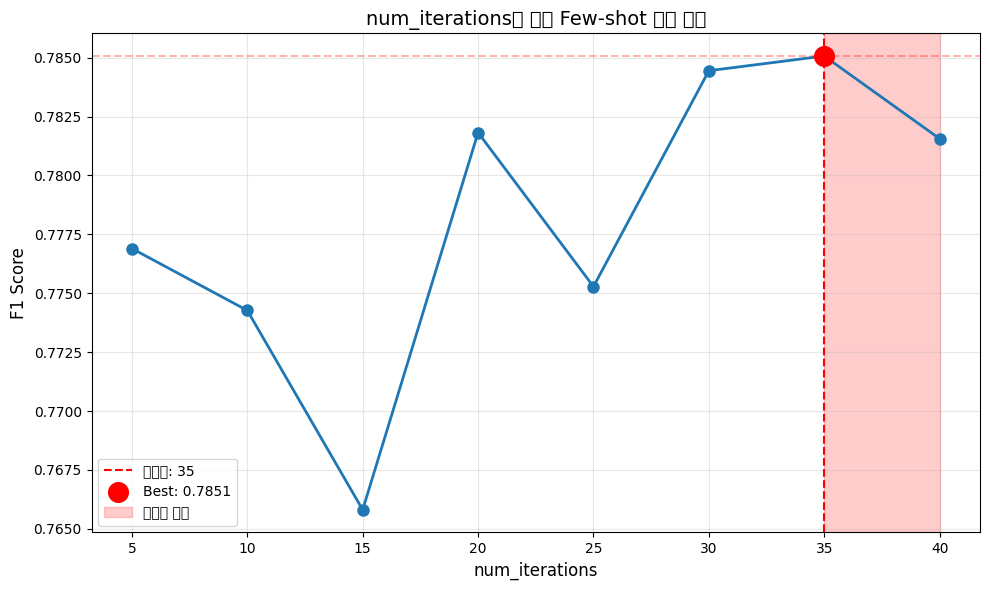


그래프 저장 완료: fewshot_iterations_analysis.png


In [ ]:
import matplotlib.pyplot as plt

# 실험할 num_iterations 범위
iterations_range = [5, 10, 15, 20, 25, 30, 35, 40]
f1_scores = []

print("=" * 50)
print("num_iterations별 성능 측정 중...")
print("=" * 50)

for n_iter in iterations_range:
    # 모델 초기화
    model = SetFitModel.from_pretrained("jhgan/ko-sroberta-multitask")

    # 학습 설정
    args = SetFitTrainingArguments(
        num_epochs=3,
        num_iterations=n_iter,
        batch_size=16
    )

    # Trainer
    trainer = SetFitTrainer(
        model=model,
        args=args,
        train_dataset=sampled_train_data,
        eval_dataset=test_data,
        metric="f1",
        column_mapping={"document": "text"}
    )

    # 학습 및 평가
    trainer.train()
    metrics = trainer.evaluate()
    f1 = metrics['f1']
    f1_scores.append(f1)

    print(f"num_iterations={n_iter:2d}: F1={f1:.4f}")

# 최적값 찾기
best_idx = f1_scores.index(max(f1_scores))
best_iter = iterations_range[best_idx]
best_f1 = f1_scores[best_idx]

print("\n" + "=" * 50)
print(f"최적 num_iterations: {best_iter}")
print(f"최고 F1 Score: {best_f1:.4f}")
print("=" * 50)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(iterations_range, f1_scores, marker='o', linewidth=2, markersize=8)
plt.axvline(x=best_iter, color='r', linestyle='--', label=f'최적값: {best_iter}')
plt.axhline(y=best_f1, color='r', linestyle='--', alpha=0.3)

# 최적점 강조
plt.scatter([best_iter], [best_f1], color='red', s=200, zorder=5,
            label=f'Best: {best_f1:.4f}')

# 과적합 영역 표시
if best_idx < len(iterations_range) - 1:
    plt.axvspan(iterations_range[best_idx], iterations_range[-1],
                alpha=0.2, color='red', label='과적합 영역')

plt.xlabel('num_iterations', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('num_iterations에 따른 Few-shot 성능 변화', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('fewshot_iterations_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n그래프 저장 완료: fewshot_iterations_analysis.png")

#### 최적 num_iterations 특정 불가

### 실험 결과
- 테스트 범위: 5~40
- 최고 성능: 35 (F1: 0.785)
- 패턴: 불규칙한 등락

### 한계
   - 매 실행마다 쌍 생성이 랜덤
   - 동일 설정도 결과 달라질 수 있음
    - **높은 노이즈로 인해 최적값 특정 어려움**

In [ ]:
model.model_head # 분류기 훈련이 완료되면 파란색

LogisticRegression()



---



## **마스크드 언어 모델링** (MLM)

### **사전 훈련된 (BERT)모델 계속 훈련하는 방법**

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# 모델: klue/bert-base
model_id = "klue/bert-base"
model = AutoModelForMaskedLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["document"], truncation=True)

# 데이터를 토큰화합니다.
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

- 마스킹 방법
    - 토큰 마스킹 : 단어 마스킹보다는 비교적 빠른 수렴
    - 전체 단어 마스킹 : 정료하지만 복잡하고 느리다
- 토큰 마스킹
    - 문장에 있는 토큰의 15%를 랜덤하게 마스킹함
    - 단어의 일부분만 마스킹 될 수 있다.

In [ ]:
from transformers import DataCollatorForLanguageModeling

# 토큰 마스킹
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [ ]:
# from transformers import DataCollatorForWholeWordMask

# # 전체 단어 마스킹
# data_collator = DataCollatorForWholeWordMask(
#     tokenizer=tokenizer,
#     mlm=True,
#     mlm_probability=0.15
# )

In [ ]:
# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


In [ ]:
# 훈련 시간이 오래 걸림(T4 20분 이상)
# 사전 훈련된 토크나이저를 저장합니다.
tokenizer.save_pretrained("mlm")

# 모델을 훈련합니다.
trainer.train()

# 업데이트된 모델을 저장합니다.
model.save_pretrained("mlm")

Step,Training Loss
500,1.924100


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


- **Mask 예측 결과 확인: (원본 모델)**

In [ ]:
from transformers import pipeline

# 모델을 로드하고 예측을 만듭니다.
mask_filler = pipeline("fill-mask", model="klue/bert-base")
preds = mask_filler("스토리가 [MASK]라서 시간 가는 줄 몰랐다.")

# 결과를 출력합니다.
for pred in preds:
    print(f">>> {pred['sequence']}")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


>>> 스토리가 너무 라서 시간 가는 줄 몰랐다.
>>> 스토리가 있 라서 시간 가는 줄 몰랐다.
>>> 스토리가 워낙 라서 시간 가는 줄 몰랐다.
>>> 스토리가 별로 라서 시간 가는 줄 몰랐다.
>>> 스토리가 라서 시간 가는 줄 몰랐다.


- **Mask 예측 결과 확인: (업데이트된 모델)**

- 영화리뷰 학습을 통해 도메인 특화 어휘와 평가 표현이 크게 개선
- 문맥적 논리성과 문법적 완성도는 추가 개선이 필요

In [ ]:
# 모델을 로드하고 예측을 만듭니다.
# 마스크 예측 결과 개수 지정 방법
mask_filler = pipeline("fill-mask", model="mlm", top_k=10)
preds = mask_filler("스토리가 [MASK]라서 시간 가는 줄 몰랐다.")

# 결과를 출력합니다.
for pred in preds:
    print(f">>> {pred['sequence']}")

Device set to use cuda:0


>>> 스토리가 별로 라서 시간 가는 줄 몰랐다.
>>> 스토리가 너무 라서 시간 가는 줄 몰랐다.
>>> 스토리가 재미 라서 시간 가는 줄 몰랐다.
>>> 스토리가 최고 라서 시간 가는 줄 몰랐다.
>>> 스토리가 뛰어나 라서 시간 가는 줄 몰랐다.
>>> 스토리가 뭐 라서 시간 가는 줄 몰랐다.
>>> 스토리가 짜 라서 시간 가는 줄 몰랐다.
>>> 스토리가 좋 라서 시간 가는 줄 몰랐다.
>>> 스토리가 진짜 라서 시간 가는 줄 몰랐다.
>>> 스토리가 남달 라서 시간 가는 줄 몰랐다.


- 기대했던 것

  "스토리가 [재미있어서] 시간 가는 줄 몰랐다"

- 실제 결과  

  "스토리가 [재미] 라서 시간 가는 줄 몰랐다"

- 원인: "재미있어서"가 다음과 같이 토큰화됨

  - 토큰들 = ["재미", "있어서"] 또는 ["재미", "##있", "##어서"]
  - 모델은 첫 번째 토큰 "재미"만 예측

In [ ]:
preds[:5]

[{'score': 0.3985593616962433,
  'token': 5429,
  'token_str': '별로',
  'sequence': '스토리가 별로 라서 시간 가는 줄 몰랐다.'},
 {'score': 0.11836191266775131,
  'token': 3760,
  'token_str': '너무',
  'sequence': '스토리가 너무 라서 시간 가는 줄 몰랐다.'},
 {'score': 0.028566410765051842,
  'token': 4697,
  'token_str': '재미',
  'sequence': '스토리가 재미 라서 시간 가는 줄 몰랐다.'},
 {'score': 0.02480860985815525,
  'token': 3841,
  'token_str': '최고',
  'sequence': '스토리가 최고 라서 시간 가는 줄 몰랐다.'},
 {'score': 0.01693551614880562,
  'token': 7999,
  'token_str': '뛰어나',
  'sequence': '스토리가 뛰어나 라서 시간 가는 줄 몰랐다.'}]

In [ ]:
len(preds)

10



---



## **개체명 인식**

- **개체명 인식** (**NER** named-entity recognition)
- 전체 문서를 분류하는 것이 아니라 **사람이나 위치 등이 포함된 개별 토큰이나 단어를 분류**함
- 민감한 데이터가 있을 때 익명화하는 작업에 특별히 도움됨
- 개별 단어를 분류하는 데 초점을 맞추려면 세분화된 구조를 고려하도록 데이터를 전처리해야 한다.
- 분류 방식:
    - **모델이 시퀀스에 있는 개별 토큰에 대해 예측**을 만든다



In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import numpy as np

In [ ]:

dataset = load_dataset("klue", "ner")

README.md: 0.00B [00:00, ?B/s]

ner/train-00000-of-00001.parquet:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

ner/validation-00000-of-00001.parquet:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/21008 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'tokens', 'ner_tags'],
        num_rows: 21008
    })
    validation: Dataset({
        features: ['sentence', 'tokens', 'ner_tags'],
        num_rows: 5000
    })
})

In [ ]:
example = dataset["train"][848]
example

{'sentence': '마지막 영화 <1분:TI>이 이영화에 대한 나의 인식을 바꿨다.',
 'tokens': ['마',
  '지',
  '막',
  ' ',
  '영',
  '화',
  ' ',
  '1',
  '분',
  '이',
  ' ',
  '이',
  '영',
  '화',
  '에',
  ' ',
  '대',
  '한',
  ' ',
  '나',
  '의',
  ' ',
  '인',
  '식',
  '을',
  ' ',
  '바',
  '꿨',
  '다',
  '.'],
 'ner_tags': [12,
  12,
  12,
  12,
  12,
  12,
  12,
  10,
  11,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12]}

- **ner_tags** : 개체명 태그
    - 사람(PER),조직(ORG), 위치(LOC), 기타매체(MISC), 개체아님(O)
    - 개체마다 B(시작),I(중간)

In [ ]:
label_list = dataset["train"].features["ner_tags"].feature.names
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}

In [ ]:
from transformers import AutoModelForTokenClassification

# 토크나이저를 로드합니다.
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model_id = "klue/bert-base"
# 모델을 로드합니다.
model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


토크나이저가 샘플을 처리하는 방법 확인

In [ ]:
example["tokens"]

['마',
 '지',
 '막',
 ' ',
 '영',
 '화',
 ' ',
 '1',
 '분',
 '이',
 ' ',
 '이',
 '영',
 '화',
 '에',
 ' ',
 '대',
 '한',
 ' ',
 '나',
 '의',
 ' ',
 '인',
 '식',
 '을',
 ' ',
 '바',
 '꿨',
 '다',
 '.']

In [ ]:
# 개별 토큰을 부분 토큰으로 나눕니다.
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

# is_split_into_words=True: 토크나이저가 단어 리스트로 처리하도록 지시 (NER 라벨 정렬에 유리)
# ["input_ids"]: 토큰화된 결과 중 정수 ID 시퀀스만 꺼냄

['[CLS]',
 '마',
 '지',
 '막',
 '영',
 '화',
 '1',
 '분',
 '이',
 '이',
 '영',
 '화',
 '에',
 '대',
 '한',
 '나',
 '의',
 '인',
 '식',
 '을',
 '바',
 '꿨',
 '다',
 '.',
 '[SEP]']

- align_labels
    - 입력을 토큰으로 나누고, 토큰을 업데이트된 레이블로 정렬하는 함수

In [ ]:
def align_labels(examples):
    # 1. 토큰들을 문장으로 재구성
    reconstructed_texts = []
    for tokens in examples["tokens"]:
        text = ''.join(tokens)
        reconstructed_texts.append(text)

    # 2. 재구성된 문장으로 토큰화
    tokenized_inputs = tokenizer(
        reconstructed_texts,
        truncation=True,
        padding=False,
        return_offsets_mapping=True  # 문자 위치 정보 포함
    )

    # 3. 라벨 정렬
    aligned_labels = []

    for batch_idx, (original_tokens, original_labels, offsets) in enumerate(
        zip(examples["tokens"], examples["ner_tags"], tokenized_inputs["offset_mapping"])
    ):

        # 원본 토큰의 문자 위치 계산
        char_to_original_token = {}
        char_pos = 0

        for token_idx, token in enumerate(original_tokens):
            for _ in range(len(token)):
                char_to_original_token[char_pos] = token_idx
                char_pos += 1

        # 서브토큰별 라벨 할당
        labels = []
        for start, end in offsets:
            if start == end == 0:  # [CLS], [SEP] 등 특수 토큰
                labels.append(-100)
            else:
                # 해당 위치의 원본 토큰 인덱스 찾기
                if start < len(char_to_original_token):
                    original_token_idx = char_to_original_token[start]
                    labels.append(original_labels[original_token_idx])
                else:
                    labels.append(-100)

        aligned_labels.append(labels)

    # offset_mapping 제거 (학습에 불필요)
    tokenized_inputs.pop("offset_mapping")
    tokenized_inputs["labels"] = aligned_labels

    return tokenized_inputs

In [ ]:
print("데이터셋 재전처리 중...")
tokenized_dataset = dataset.map(align_labels, batched=True)

# 결과 확인
sample_idx = 848
print(f"\n=== 샘플 {sample_idx} 재전처리 결과 ===")
original_sample = dataset["train"][sample_idx]
processed_sample = tokenized_dataset["train"][sample_idx]

print(f"원본 문장: {original_sample['sentence']}")
print(f"재구성된 문장: {''.join(original_sample['tokens'])}")

# 토큰화 결과 확인
tokens = tokenizer.convert_ids_to_tokens(processed_sample['input_ids'])
labels = processed_sample['labels']

print(f"\n토큰 vs 라벨:")
for token, label in zip(tokens, labels):
    label_name = id2label[label] if label != -100 else "IGNORE"
    print(f"  {token:15} -> {label_name}")

데이터셋 재전처리 중...


Map:   0%|          | 0/21008 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]


=== 샘플 848 재전처리 결과 ===
원본 문장: 마지막 영화 <1분:TI>이 이영화에 대한 나의 인식을 바꿨다.
재구성된 문장: 마지막 영화 1분이 이영화에 대한 나의 인식을 바꿨다.

토큰 vs 라벨:
  [CLS]           -> IGNORE
  마지막             -> O
  영화              -> O
  1               -> B-TI
  ##분             -> I-TI
  ##이             -> O
  이영              -> O
  ##화             -> O
  ##에             -> O
  대한              -> O
  나               -> O
  ##의             -> O
  인식              -> O
  ##을             -> O
  바꿨              -> O
  ##다             -> O
  .               -> O
  [SEP]           -> IGNORE


In [ ]:
!pip install seqeval

In [ ]:
import evaluate

# seqeval을 로드합니다.
seqeval = evaluate.load("seqeval")

# 평가 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    for prediction, label in zip(predictions, labels):
        for token_prediction, token_label in zip(prediction, label):
            if token_label != -100:
                true_predictions.append([id2label[token_prediction]])
                true_labels.append([id2label[token_label]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

In [ ]:
from transformers import DataCollatorForTokenClassification

# 토큰 분류 DataCollator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
# 훈련 설정
training_args = TrainingArguments(
    "model_ner_ko",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,  # 에폭 수 증가
    weight_decay=0.01,
    save_strategy="epoch",
    eval_strategy="epoch",
    report_to="none",
    logging_steps=100
)

# 트레이너 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.065100,0.069436,0.942620
2,0.038200,0.072277,0.944241


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/py

TrainOutput(global_step=2626, training_loss=0.056652990262742633, metrics={'train_runtime': 151.6937, 'train_samples_per_second': 276.979, 'train_steps_per_second': 17.311, 'total_flos': 1279297320963360.0, 'train_loss': 0.056652990262742633, 'epoch': 2.0})

In [ ]:
# 테스트 데이터에서 모델을 평가합니다.
trainer.evaluate()

{'eval_loss': 0.0722770169377327,
 'eval_f1': 0.9442410802436321,
 'eval_runtime': 11.1669,
 'eval_samples_per_second': 447.754,
 'eval_steps_per_second': 28.029,
 'epoch': 2.0}

- **모델 저장 및 추론 수행**

In [ ]:
from transformers import pipeline
from collections import defaultdict

# 미세 튜닝된 모델을 저장합니다.
trainer.save_model("ner_model-ko")



# 미세 튜닝된 모델로 추론을 수행합니다.
token_classifier = pipeline(
    "token-classification",
    model="ner_model-ko",
    aggregation_strategy="simple"
)
text = """
2024년 3월 15일 오후 3시에 삼성전자 임직원 500명이 서울대학교에서 열린
'인공지능과 미래사회' 세미나에 참석했다. 이 행사에서 김철수 교수는
조선시대 이순신 장군의 리더십을 현대 경영학에 접목한 연구를 발표했으며,
구글코리아 박지영 대표는 50억원 규모의 AI 투자 계획을 발표했다.
행사장인 부산 해운대 벡스코에서는 삼겹살과 김치를 포함한 한식 뷔페가
제공되었고, 참가자들은 갤럭시 스마트폰으로 QR코드를 스캔하여
디지털 명함을 교환했다.
"""
result = token_classifier(text)
# 유형별로 분류
entities_by_type = defaultdict(list)
for entity in result:
    entities_by_type[entity['entity_group']].append(entity['word'])

print("🏷️ 엔티티 분류 결과:")
print("-" * 30)

for entity_type, words in sorted(entities_by_type.items()):
    print(f"{entity_type}: {', '.join(words)}")

Device set to use cuda:0


🏷️ 엔티티 분류 결과:
------------------------------
DT: 2024년 3월 15일, 조선시대
LC: 서울대학교, 부산 해운대 벡스코
OG: 삼성전자, 구글코리아
PS: 김철수, 이순신, 박지영
QT: 500명, 50억원
TI: 오후 3시


klue_entities = {
    # 인물 관련
    'PS': 'Person - 인명 (박지성, 김철수, 이순신 등)',
    
    # 장소 관련  
    'LC': 'Location - 지명 (서울, 부산, 맨체스터 등)',
    
    # 기관 관련
    'OG': 'Organization - 기관명 (삼성전자, 서울대학교, 맨체스터 유나이티드 등)',
    
    # 날짜/시간
    'DT': 'Date/Time - 날짜/시간 (2024년, 오늘, 3시 등)',
    
    # 수량
    'QT': 'Quantity - 수량 (100개, 50%, 3명 등)',
    
    # 기타 고유명사
    'CV': 'Civilization - 문명/문화 (조선시대, 르네상스 등)',
    'AM': 'Animal - 동물명',
    'PT': 'Plant - 식물명',
    'MT': 'Material - 물질명',
    'TI': 'Title - 작품명/타이틀',
    'EV': 'Event - 사건명',
    'AF': 'Artifact - 인공물',
    'TR': 'Term - 용어',
    'FD': 'Food - 음식명',
}